# H3 and (Multi)Polygons

`h3-py` can convert between sets of cells and GeoJSON-like polygon and multipolygon shapes.

We use the abstract base class `H3Shape` and its concrete child classes `H3Poly` and `H3MultiPoly`
to represent these shapes. 
Any references or function names that use "H3Shape" will apply to both `H3Poly` and `H3MultiPoly` objects.

`h3-py` is also compatible with Python objects that implement `__geo_interface__` (https://gist.github.com/sgillies/2217756),
making it easy to interface with other Python geospatial libraries.
We'll refer to any such object as a "geo" or "geo object".

`H3Poly` and `H3MultiPoly` both implement `__geo_interface__` (making them geo objects themselves),
and can be created from other geo objects, like Shapely's `Polygon` or `MultiPolygon` objects that occur
when using `geopandas`.

Below, we'll explain the `h3-py` API for working with these shapes, and how the library interacts
with other Python geospatial libraries.

To start, we'll import relevant libraries, and define some plotting helper functions to visualize the shapes we're dealing with.

In [1]:
import h3

import geopandas
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt

def plot_df(df, column=None, ax=None):
    'Plot based on the `geometry` column of a GeoPandas dataframe'
    df = df.copy()
    df = df.to_crs(epsg=3857) # web mercator

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    df.plot(
        ax=ax,
        alpha=0.5, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'}, 
    )
    cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Positron)

def plot_shape(shape, ax=None):
    df = geopandas.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax)

def plot_cells(cells, ax=None):
    shape = h3.cells_to_h3shape(cells)
    plot_shape(shape, ax=ax)

def plot_shape_and_cells(shape, res=9):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    plot_shape(shape, ax=axs[0])
    plot_cells(h3.h3shape_to_cells(shape, res), ax=axs[1])
    fig.tight_layout()

# H3Poly

We can create a simple `H3Poly` object by providing a list of the **latitude/longitude pairs** that describe its exterior.
Optionally, holes can be added to the polygon by appending additional lat/lng lists do describe them.

In [ ]:
outer = [
    (37.804, -122.412),
    (37.778, -122.507),
    (37.733, -122.501)
]

poly = h3.H3Poly(outer)
print(poly)
plot_shape(poly)

In [ ]:
hole1 = [
    (37.782, -122.449),
    (37.779, -122.465),
    (37.788, -122.454),
]

poly = h3.H3Poly(outer, hole1)
print(poly)
plot_shape(poly)

In [ ]:
hole2 = [
    (37.771, -122.484),
    (37.761, -122.481),
    (37.758, -122.494),
    (37.769, -122.496),
]

poly = h3.H3Poly(outer, hole1, hole2)
print(poly)
plot_shape(poly)

## String representation and attributes

The `H3Poly` string representation given by its `__repr__` shows the number of vertices in the outer loop of the polygon, followed
by the number of vertices in each hole.

A representation like

```
<H3Poly: [3/(3, 4)]>
```

denotes a polygon whose outer boundary consists of 3 vertices and which has 2 holes,
with 3 and 4 vertices respectively.

We can access the coordinates describing the polygon through the attributes:

- `H3Poly.outer` gives the list of lat/lng points making up the outer loop of the polygon.
- `H3Poly.holes` gives each of the lists of lat/lng points making up the holes of the polygon.

In [ ]:
poly = h3.H3Poly(outer, hole1, hole2)
poly

In [ ]:
poly.outer

In [ ]:
poly.holes

## `__geo_interface__`

`H3Poly.__geo_interface__` gives a GeoJSON representation of the polygon as described in https://gist.github.com/sgillies/2217756

**Note the differences in this representation**: Points are given in **lng/lat** order (but the `H3Poly` constructor expects **lat/lng** order), and the last vertex repeats the first.

In [ ]:
d = poly.__geo_interface__
d

In [ ]:
print(poly.outer)
print(poly.holes)

We can create an `H3Poly` object from a GeoJSON-like dictionary or an object that implements `__geo_interface__` using `h3.geo_to_h3shape()`.

In [ ]:
h3.geo_to_h3shape(d)

In [ ]:
class MockGeo:
    def __init__(self, d):
        self.d = d

    @property
    def __geo_interface__(self):
        return self.d

geo = MockGeo(d)
h3.geo_to_h3shape(geo)

Also note that `H3Poly.__geo_interface__` is equivalent to calling `h3.h3shape_to_geo()` on an `H3Poly` object.

In [ ]:
poly.__geo_interface__ == h3.h3shape_to_geo(poly)

## Polygon to cells

We can get all the H3 cells whose centroids fall within an `H3Poly` by using `h3.h3shape_to_cells()` and specifying the resolution.

In [ ]:
h3.h3shape_to_cells(poly, res=7)

We'll use a helper function to show a few different resolutions.

In [ ]:
plot_shape_and_cells(poly, 7)

In [ ]:
plot_shape_and_cells(poly, 9)

In [ ]:
plot_shape_and_cells(poly, 10)

## H3 Polygons don't need to follow the right-hand rule

`H3Poly` objects do not need to follow the "right-hand rule", unlike GeoJSON Polygons. 
The right-hand rule requires that vertices in outer loops are listed in counterclockwise
order and holes are listed in clockwise order.
`h3-py` accepts loops in any order and will usually interpret them as the user intended, for example,
converting to sets of cells. However, `h3-py` won't re-order your loops to
conform to the right-hand rule, so be careful if you're using `__geo_interface__` to plot them.

Obeying the right-hand rule is only a concern when creating `H3Poly` objects from external input; `H3Poly` or `H3MultiPoly`
objects created through `h3.cells_to_shape()` **will respect the right-hand rule**.

For example, if we reverse the order of one of the holes in our example polygon above,
the hole won't be rendered correctly, but the conversion to cells will remain unchanged.

In [ ]:
# Respects right-hand rule
poly = h3.H3Poly(outer, hole1, hole2)
plot_shape_and_cells(poly, res=10)

In [ ]:
# Does not respect right-hand-rule; second hole is reversed
# Conversion to cells still works, tho!
poly = h3.H3Poly(outer, hole1[::-1], hole2)
plot_shape_and_cells(poly, res=10)

In [ ]:
# Does not respect right-hand-rule; outer loop and second hole are both reversed
# Conversion to cells still works, tho!
poly = h3.H3Poly(outer[::-1], hole1[::-1], hole2)
plot_shape_and_cells(poly, res=10)

# H3MultiPoly

An `H3MultiPoly` can be created from `H3Poly` objects. The string representation of the `H3MultiPoly`
gives the number of vertices in the outer loop of each `H3Poly`, along with the number of vertices
in each hole (if there are any).

For example `<H3MultiPoly: [3], [4/(5,)]>` represents an `H3MultiPoly` consisting of two `H3Poly` polygons:

- the first polygon has 3 outer vertices and no holes
- the second polygon has 4 outer vertices and 1 hole with 5 vertices

In [ ]:
poly1 = h3.H3Poly([(37.804, -122.412), (37.778, -122.507), (37.733, -122.501)])
poly2 = h3.H3Poly(
    [(37.803, -122.408), (37.736, -122.491), (37.738, -122.380), (37.787, -122.39)],
    [(37.760, -122.441), (37.772, -122.427), (37.773, -122.404), (37.758, -122.401), (37.745, -122.428)]
)
mpoly = h3.H3MultiPoly(poly1, poly2)

print(poly1)
print(poly2)
print(mpoly)

In [ ]:
plot_shape(mpoly)

## MultiPolygon to cells

`h3.h3shape_to_cells()` works on both `H3MultiPoly` and `H3Poly` objects (both are subclasses of `H3Shape`).

In [ ]:
cells = h3.h3shape_to_cells(mpoly, res=9)
plot_cells(cells)

## H3MultiPoly affordances

- Calling `len()` on an `H3MultiPoly` gives the number of polygons
- You can iterate through a `H3MultiPoly`, with the elements being the underlying `H3Poly`s

In [ ]:
len(mpoly)

In [ ]:
for p in mpoly:
    print(p)

In [ ]:
list(mpoly)

## `__geo_interface__`

`H3MultiPoly` implements `__geo_interface__`, and `H3MultiPoly` objects can also be created through `h3.geo_to_h3shape()`.

In [ ]:
d = mpoly.__geo_interface__
d

In [ ]:
geo = MockGeo(d)
h3.geo_to_h3shape(geo)

# Cells to H3Poly or H3MultiPoly

If you have a set of H3 cells that you would like to visualize, you may want to convert them to `H3Poly` or `H3MultiPoly` objects using `h3.cells_to_h3shape()` and then use `__geo_interface__` to get their GeoJSON representation. Or you could
use `h3.cells_to_geo()` to get the GeoJSON dictionary directly.

In [ ]:
h = h3.latlng_to_cell(37.804, -122.412, res=9)
cells = h3.grid_ring(h, 2)
cells

In [ ]:
plot_cells(cells)

In [ ]:
h3.cells_to_h3shape(cells)

In [ ]:
str(h3.cells_to_geo(cells))[:200]

# API Summary

```
"Geo object" <-> H3Shape <-> H3 cells
```

"Geo objects" are any Python object that implements `__geo_interface__`. This is a widely used
standard in geospatial Python and is used by libraries like `geopandas` and Shapely.

`H3Shape` is an abstract class implemented by `H3Poly` and `H3MultiPoly`, each of which
implement `__geo_interface__` and can be created from external "Geo objects":

- `geo_to_h3shape()`
- `h3shape_to_geo()`

`H3Shape` objects can be converted to and from sets of H3 cells:

- `h3shape_to_cells()`
- `cells_to_h3shape()`

For convience, we provide functions that hide the intermediate `H3Shape` representation:

- `geo_to_cells()`
- `cells_to_geo()`

## Equivalance notes

Note that if an object `a` is an `H3Shape`
then the following two expressions are equivalent:

- `h3shape_to_geo(a)`
- `a.__geo_interface__`

Also note that if `a` is an `H3Shape`, then `a` "passes through" `geo_to_h3shape()`:

```python
geo_to_h3shape(a) == a
```

# Interfacing with GeoPandas and other libraries

The `__geo_interface__` compatibility allows `h3-py` to work with `geopandas` and other geospatial libraries easily.

To demonstrate, we start with a GeoPandas `GeoDataFrame` describing the five New York City boroughs.

In [2]:
df = geopandas.read_file(geodatasets.get_path('nybb'))
df

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


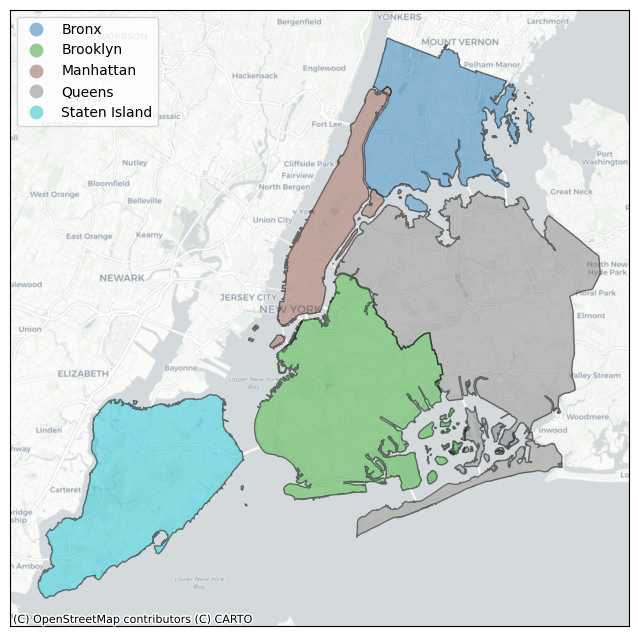

In [3]:
plot_df(df, column='BoroName')

## Use a compatible CRS before applying H3 functions

The function `h3.geo_to_cells(geo, res)` takes some "geo object" that implements `__geo_interface__` (https://gist.github.com/sgillies/2217756) — like a Shapely Polygon or MultiPolygon — and converts it to the set of cells whose centroids are contained in `geo`.

**Common Pitfall**: Be careful about what CRS you are using. `h3-py` expects coordinates as latitude-longitude pairs. The CRS of the current dataframe (EPSG:2263) gives coordinates in feet! You should first convert the data to something compatible. A common choice is **EPSG:4326/WGS84**. You'll get incorrect results if you apply `h3.geo_to_cells` without converting.

In [4]:
# Original CRS
df.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

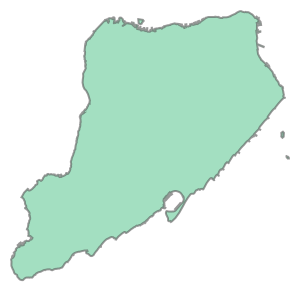

In [8]:
df.geometry[0]

In [ ]:
# Converting to EPSG:4326/WGS84
df = df.to_crs(epsg=4326)
df.crs

In [ ]:
# Note that the `geometry` column now has coordinates in degrees
df

## Converting a geo to H3 cells

First, we select one of the boroughs and get the Shapely `MultiPolygon` describing it.

In [ ]:
geo = df.geometry[0]
type(geo)

Note that Shapely `MultiPolygon` objects implement `__geo_interface__`, so we can use `h3.geo_to_cells()` to get the associated set of H3 cells at various resolutions.

In [ ]:
h3.geo_to_cells(geo, res=6)

In [ ]:
plot_cells(h3.geo_to_cells(geo, res=9))

## Converting all geos in a GeoDataFrame to cells

We can apply `geo_to_cells()` to each of the Shapely geometries in the `df.geometry` column.

In [ ]:
cell_column = df.geometry.apply(lambda x: h3.geo_to_cells(x, res=8))
cell_column

## Converting cells to "geo objects"

If we assign `df.geometry = cell_column` we'll get an error because the `geometry` column of a `geopandas.GeoDataFrame` must contain valid geometry objects.
We can obtain compatible objects by converting the cells to `H3Shape` by applying `h3.cells_to_h3shape()`.

(Note that, unfortunately, Pandas has some logic to identify iterable members of a series and then renders a tuple of the elements, rather than our preferred `H3MultiPoly.__repr__` representation.)

In [ ]:
shape_column = cell_column.apply(h3.cells_to_h3shape)
shape_column

Note that the column now consists of `H3Poly` and `H3MultiPoly` objects.

In [ ]:
shape_column[0]

In [ ]:
shape_column[1]

Now, if we assign `df.geometry = shape_column`, our `H3Shape` objects will automatically be converted to Shapely Polygon and MultiPolygon objects via `__geo_interface__`.

In [ ]:
df.geometry = shape_column
df.geometry

In [ ]:
type(df.geometry[0])

## Visualizing H3 cells

We took some Shapely geometry objects, converted them to H3 cells, and converted those back to Shapely geometry objects in a `geopandas.GeoDataFrame`. 

We can visualize the results with our helper function.

In [ ]:
plot_df(df, column='BoroName')